In [141]:
import pandas as pd
import scipy.io
import numpy as np
from scipy.spatial.distance import pdist, squareform
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
rand_state = 42
np.random.seed(rand_state)

**QM7** is a subset of GDB-13 (a database of nearly 1 billion stable and synthetically accessible organic molecules) containing up to 7 heavy atoms C, N, O, and S. The 3D Cartesian coordinates of the most stable conformations and their atomization energies were determined using ab-initio density functional theory (PBE0/tier2 basis set).This dataset also provided Coulomb matrices as calculated in [Rupp et al. PRL, 2012]:  
  * $C_{i,i} = 0.5 \cdot Z^2.4$  
  * $C_{i,j} = Z_i \cdot \frac{Z_j}{|(R_i−R_j)|}$ 
  * $Z_i$ - nuclear charge of atom i  
  * $R_i$ - cartesian coordinates of atom i  

The data file (.mat format, we recommend using `scipy.io.loadmat` for python users) contains five arrays:  
  * "X" - (7165 x 23 x 23), Coulomb matrices  
  * "T" - (7165), atomization energies (unit: kcal/mol)  
  * "P" - (5 x 1433), cross-validation splits as used in [Montavon et al. NIPS, 2012]  
  * "Z" - (7165 x 23), atomic charges  
  * "R" - (7165 x 23 x 3), cartesian coordinate (unit: Bohr) of each atom in the molecules  

Reference:  
Rupp, Matthias, et al. "Fast and accurate modeling of molecular atomization energies with machine learning." Physical review letters 108.5 (2012): 058301.
Montavon, Grégoire, et al. "Learning invariant representations of molecules for atomization energy prediction." Advances in Neural Information Processing Systems. 2012.  

For this model, I take the upper triangle of each Coulomb Matrix (with diagonal) and unroll it so each has the shape: (1, num_atoms*(num_atoms+1)/2). I then compute the pairwise distance matrix and from this get the corresponding Eigenvalues and [Eigenvector Centralities](https://en.wikipedia.org/wiki/Eigenvector_centrality). I am attempting to estimate the influence one particular atom plays on the entire molecule; typically this is performed on an adjacency matrix (graph), however, I am assuming the connectivity (bonds) are not known upfront (can be accurately predicted via Monte Carlo simulations).  

This study is primarily based off two previous studies: a 2016 publication by [B. Himmetoglu](https://arxiv.org/abs/1609.07124) and a team of researchers at [Stanford](http://moleculenet.ai). The earlier work by Himmetoglu reported a RMSE of 38.75 kcal/mol on the train set and 36.83 on the test set. I was not able to find the full results from the team at Stanford, however, on their [site](http://moleculenet.ai/latest-results) they list a MAE of 8.56 (I am assuming that this metric comes from evaluating their TensorFlow regression model on the test set).

In [164]:
qm7 = scipy.io.loadmat('./data/qm7.mat')
X_cm = qm7['X']
# compute the Eigenvectors of the pairwise distance matrix?
R = qm7['R']
y = np.transpose(qm7['T'])


k=0 # 0 = include diagnol, 1 = do not include diagnol
iu = np.triu_indices(num_atoms,k=k) 
num_atoms = X_cm.shape[1]
data_CM = np.zeros((X_cm.shape[0], num_atoms*(num_atoms+1)//2), dtype=float)
data_eigs = np.zeros((X_cm.shape[0], num_atoms), dtype=float)
data_centralities = np.zeros((X_cm.shape[0], num_atoms), dtype=float)

for i, cm in enumerate(X_cm):
    coulomb_vector = cm[iu]
    # Sort elements by decreasing order
    shuffle = np.argsort(-coulomb_vector)
    data_CM[i] = coulomb_vector[shuffle]
    
    dist = squareform(pdist(R[i]))
    w,v = np.linalg.eig((dist))
    data_eigs[i] = w[np.argsort(-w)]
    
    data_centralities[i] = np.array(list(nx.eigenvector_centrality(nx.Graph(dist)).values()))
    
X = np.concatenate((data_CM, data_eigs, data_centralities), axis=1)

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part


In [254]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.3, 
                                                    random_state=rand_state)


I am using 5-fold cross validation, so no need to split into train and test sets.

In [294]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score

data_dmatrix = xgb.DMatrix(data=X,label=y)

params = {"objective":"reg:linear",
          'subsample': 0.7,
          'colsample_bytree': 0.2,
          'learning_rate': 0.09,
          'max_depth': 6, 
          'seed': rand_state}

model = xgb.XGBRegressor(**params, n_estimators=100)
model.fit(X_train, y_train, 
          verbose=False,
          eval_metric='mae', 
          early_stopping_rounds=50, 
          eval_set=[(X_test, y_test)] )

#res = model.evals_result()['validation_0']['mae']
#plt.plot(res)

print("R2 (Train): ", model.score(X_train, y_train))
print("MAE (Train): ", mean_absolute_error(y_train, model.predict(X_train)))
y_pred = model.predict(X_test)
print("R2 (Test): ", r2_score(y_test, y_pred))
print("MAE (test): ", mean_absolute_error(y_test, y_pred))

R2 (Train):  0.999136966570304
MAE (Train):  5.062065
R2 (Test):  0.9965743505441499
MAE (test):  8.714102


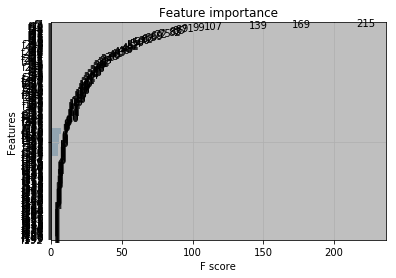

In [295]:
from xgboost import plot_importance

# plot feature importance
plot_importance(model)